In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
from datasets import load_dataset
dataset = load_dataset("ag_news")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
df = dataset['train'].to_pandas()[['text', 'label']]
df = df.dropna().reset_index(drop=True)
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
# Limit to 2000 samples (500 per class)
df_subset = (
    df.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(n=1000, random_state=42))
    .reset_index(drop=True)
)

# Proceed with this subset for training
df = df_subset.copy()


<ipython-input-5-a15c49894f45>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=1000, random_state=42))


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [ ]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X_pad = pad_sequences(sequences, padding='post')
vocab_size = len(tokenizer.word_index) + 1
max_len = X_pad.shape[1]

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])


import numpy as np

def create_triplets(X, y, num_triplets=30000):
    label_to_indices = {}
    for idx, label in enumerate(y):
        label_to_indices.setdefault(label, []).append(idx)

    triplets = []
    for _ in range(num_triplets):
        anchor_label = np.random.choice(list(label_to_indices.keys()))
        anchor_idx = np.random.choice(label_to_indices[anchor_label])
        positive_idx = np.random.choice([i for i in label_to_indices[anchor_label] if i != anchor_idx])
        negative_label = np.random.choice([l for l in label_to_indices.keys() if l != anchor_label])
        negative_idx = np.random.choice(label_to_indices[negative_label])
        triplets.append((anchor_idx, positive_idx, negative_idx))

    return np.array(triplets)

triplets = create_triplets(X_pad, labels, num_triplets=30000)
anchor_input = X_pad[triplets[:, 0]]
positive_input = X_pad[triplets[:, 1]]
negative_input = X_pad[triplets[:, 2]]



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def triplet_loss(margin=0.5):
    def _loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, 3, axis=1)
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return _loss


In [ ]:
def build_encoder(vocab_size, max_len, embedding_dim=64):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(3)(x)
    # Wrap tf.nn.l2_normalize in a Lambda layer
    x = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)  # Sphere projection
    return Model(inputs=inp, outputs=x, name="sphere_encoder")

encoder = build_encoder(vocab_size, max_len)

In [ ]:
anchor_in = layers.Input(shape=(max_len,), name="anchor")
positive_in = layers.Input(shape=(max_len,), name="positive")
negative_in = layers.Input(shape=(max_len,), name="negative")

encoded_a = encoder(anchor_in)
encoded_p = encoder(positive_in)
encoded_n = encoder(negative_in)

merged = layers.Concatenate(axis=1)([encoded_a, encoded_p, encoded_n])
triplet_model = Model(inputs=[anchor_in, positive_in, negative_in], outputs=merged)
triplet_model.compile(optimizer='adam', loss=triplet_loss())

# Train model
triplet_model.fit(
    [anchor_input, positive_input, negative_input],
    np.zeros(len(anchor_input)),  # dummy labels
    batch_size=128,
    epochs=5  # increase if needed
)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4961
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3400
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022


In [ ]:
# Use encoder directly
X_embed_sphere = encoder.predict(X_pad)
np.save("ag_news_sphere_embeddings.npy", X_embed_sphere)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


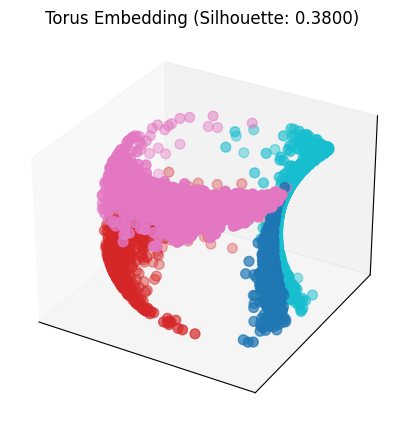

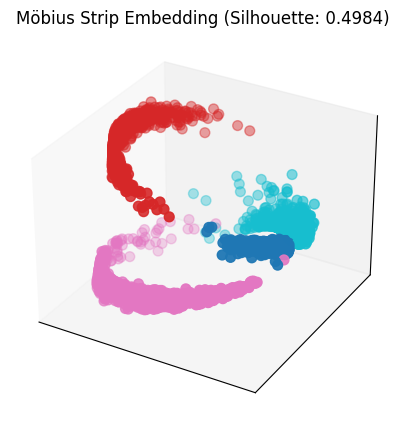

,Manifold,Silhouette Score
0,Torus,0.380016
1,Möbius,0.498396


In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Normalize the input embeddings before projection
normalized = (X_embed_sphere - X_embed_sphere.mean(axis=0)) / X_embed_sphere.std(axis=0)

# --- Torus Projection (x,y wrapped with sin/cos, z kept as is) ---
theta = 2 * np.pi * (normalized[:, 0] - normalized[:, 0].min()) / (normalized[:, 0].ptp() + 1e-8)
phi = 2 * np.pi * (normalized[:, 1] - normalized[:, 1].min()) / (normalized[:, 1].ptp() + 1e-8)
r, R = 1.0, 2.0  # torus radii
x_torus = (R + r * np.cos(phi)) * np.cos(theta)
y_torus = (R + r * np.cos(phi)) * np.sin(theta)
z_torus = r * np.sin(phi)
torus_embeds = np.vstack([x_torus, y_torus, z_torus]).T
sil_torus = silhouette_score(torus_embeds, labels)

# --- Möbius Projection ---
theta_mob = 2 * np.pi * (normalized[:, 0] - normalized[:, 0].min()) / (normalized[:, 0].ptp() + 1e-8)
w = (normalized[:, 1] - normalized[:, 1].min()) / (normalized[:, 1].ptp() + 1e-8) - 0.5
R_mob = 1
x_mobius = (R_mob + w * np.cos(theta_mob / 2)) * np.cos(theta_mob)
y_mobius = (R_mob + w * np.cos(theta_mob / 2)) * np.sin(theta_mob)
z_mobius = w * np.sin(theta_mob / 2)
mobius_embeds = np.vstack([x_mobius, y_mobius, z_mobius]).T
sil_mobius = silhouette_score(mobius_embeds, labels)

# --- Plotting ---
def plot_3d_projection(embeds, labels, title):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], c=labels, cmap='tab10', s=50)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.show()

plot_3d_projection(torus_embeds, labels, f"Torus Embedding (Silhouette: {sil_torus:.4f})")
plot_3d_projection(mobius_embeds, labels, f"Möbius Strip Embedding (Silhouette: {sil_mobius:.4f})")

# Return scores for comparison
silhouette_results = pd.DataFrame({
    'Manifold': ['Torus', 'Möbius'],
    'Silhouette Score': [sil_torus, sil_mobius]
})

silhouette_results

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])

# 1. Split
X_train, X_test, y_train, y_test = train_test_split(X_embed_sphere, labels, test_size=0.2, random_state=42)

# 2. Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)
acc_log = accuracy_score(y_test, log_preds)

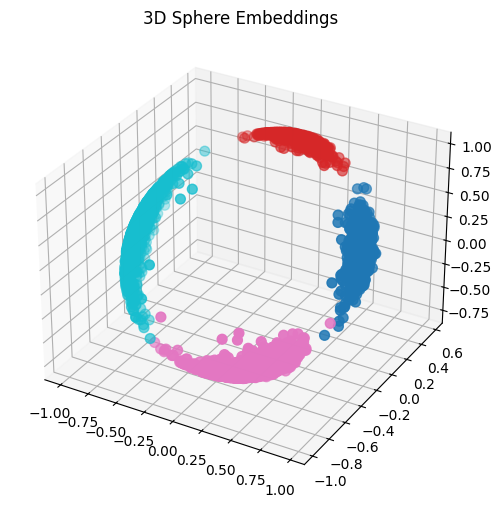

In [ ]:
# 3. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, rf_preds)

# 4. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, nb_preds)

# 5. Silhouette Score
silhouette = silhouette_score(X_embed_sphere, labels)

# 6. Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embed_sphere[:, 0], X_embed_sphere[:, 1], X_embed_sphere[:, 2],
           c=labels, cmap='tab10', s=50)
ax.set_title("3D Sphere Embeddings")
plt.show()

In [ ]:
# 7. Results
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes"],
    "Accuracy": [acc_log, acc_rf, acc_nb]
})
silhouette_value = pd.DataFrame({"Metric": ["Silhouette Score"], "Value": [silhouette]})

In [ ]:
results_df

,Model,Accuracy
0,Logistic Regression,0.99875
1,Random Forest,0.99875
2,Naive Bayes,0.99875


In [ ]:
silhouette_value

,Metric,Value
0,Silhouette Score,0.770499


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Reuse tokenizer from before (or re-initialize)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X_pad_keras = pad_sequences(sequences, padding='post')
max_len = X_pad_keras.shape[1]
vocab_size = len(tokenizer.word_index) + 1
# Redefine model
def build_keras_encoder(vocab_size, max_len, embedding_dim=64):
    inp = Input(shape=(max_len,))
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(3)(x)  # still output 3D embeddings
    return Model(inputs=inp, outputs=x, name="keras_encoder")

keras_encoder = build_keras_encoder(vocab_size, max_len)

# Use dummy targets for MSE loss (self-supervised)
dummy_y = np.random.rand(X_pad_keras.shape[0], 3)

# Compile and train
keras_encoder.compile(optimizer='adam', loss='mse')
keras_encoder.fit(X_pad_keras, dummy_y, epochs=5, batch_size=128)

# Get embeddings
X_embed_keras = keras_encoder.predict(X_pad_keras)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1441
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0879
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0854
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0848
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
X_embed_keras

array([[0.4843282 , 0.5269678 , 0.50085896],
       [0.52042156, 0.585157  , 0.53754586],
       [0.48429382, 0.49391928, 0.49513888],
       ...,
       [0.5204622 , 0.5599671 , 0.5259829 ],
       [0.2761572 , 0.20055036, 0.2745469 ],
       [0.48711854, 0.5338792 , 0.51527   ]], dtype=float32)

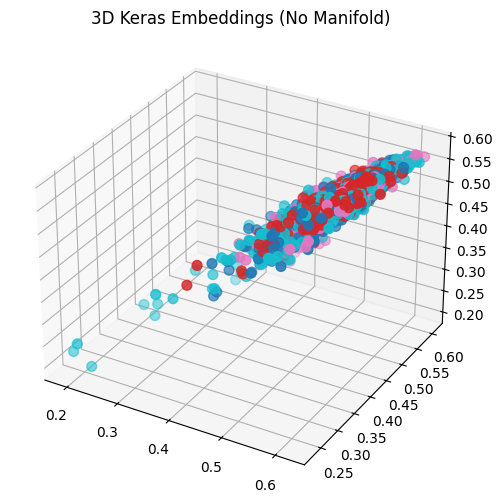

,Model,Accuracy
0,Logistic Regression,0.27750
1,Random Forest,0.26625
2,Naive Bayes,0.28250


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])
# Split data
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_embed_keras, labels, test_size=0.2, random_state=42)

# Logistic Regression
log_model_k = LogisticRegression(max_iter=1000)
log_model_k.fit(X_train_k, y_train_k)
log_preds_k = log_model_k.predict(X_test_k)
acc_log_k = accuracy_score(y_test_k, log_preds_k)

# Random Forest
rf_model_k = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_k.fit(X_train_k, y_train_k)
rf_preds_k = rf_model_k.predict(X_test_k)
acc_rf_k = accuracy_score(y_test_k, rf_preds_k)

# Naive Bayes
nb_model_k = GaussianNB()
nb_model_k.fit(X_train_k, y_train_k)
nb_preds_k = nb_model_k.predict(X_test_k)
acc_nb_k = accuracy_score(y_test_k, nb_preds_k)

# Silhouette Score
silhouette_k = silhouette_score(X_embed_keras, labels)

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embed_keras[:, 0], X_embed_keras[:, 1], X_embed_keras[:, 2],
           c=labels, cmap='tab10', s=50)
ax.set_title("3D Keras Embeddings (No Manifold)")
plt.show()

# Results table
results_df_k = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes"],
    "Accuracy": [acc_log_k, acc_rf_k, acc_nb_k]
})
silhouette_value_k = pd.DataFrame({"Metric": ["Silhouette Score"], "Value": [silhouette_k]})
results_df_k

In [ ]:
silhouette_value_k

,Metric,Value
0,Silhouette Score,-0.057073


In [ ]:
!pip install --upgrade numpy
!pip install --upgrade gensim --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 99.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 185.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split
import re

# --- TF-IDF ---
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['text']).toarray()
X_tfidf_3d = PCA(n_components=3).fit_transform(X_tfidf)

# Classifier
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)
log_tf = LogisticRegression(max_iter=1000).fit(X_train_tf, y_train_tf)
rf_tf = RandomForestClassifier().fit(X_train_tf, y_train_tf)
nb_tf = GaussianNB().fit(X_train_tf, y_train_tf)

acc_log_tf = accuracy_score(y_test_tf, log_tf.predict(X_test_tf))
acc_rf_tf = accuracy_score(y_test_tf, rf_tf.predict(X_test_tf))
acc_nb_tf = accuracy_score(y_test_tf, nb_tf.predict(X_test_tf))
sil_tf = silhouette_score(X_tfidf_3d, labels)

# --- Word2Vec ---
tokenized = df['text'].str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4, seed=42)

def avg_word2vec(text):
    words = re.sub(r'[^a-z0-9\s]', '', text.lower()).split()
    vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

X_w2v = np.vstack([avg_word2vec(t) for t in df['text']])
X_w2v_3d = PCA(n_components=3).fit_transform(X_w2v)

# Classifier
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, labels, test_size=0.2, random_state=42)
log_w2v = LogisticRegression(max_iter=1000).fit(X_train_w2v, y_train_w2v)
rf_w2v = RandomForestClassifier().fit(X_train_w2v, y_train_w2v)
nb_w2v = GaussianNB().fit(X_train_w2v, y_train_w2v)

acc_log_w2v = accuracy_score(y_test_w2v, log_w2v.predict(X_test_w2v))
acc_rf_w2v = accuracy_score(y_test_w2v, rf_w2v.predict(X_test_w2v))
acc_nb_w2v = accuracy_score(y_test_w2v, nb_w2v.predict(X_test_w2v))
sil_w2v = silhouette_score(X_w2v_3d, labels)



NameError: name 'pd' is not defined

In [ ]:
import pandas as pd


# Combine results
results_phase3 = pd.DataFrame({
    "Embedding Type": ["TF-IDF", "TF-IDF", "TF-IDF", "Word2Vec", "Word2Vec", "Word2Vec"],
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes"] * 2,
    "Accuracy": [acc_log_tf, acc_rf_tf, acc_nb_tf, acc_log_w2v, acc_rf_w2v, acc_nb_w2v]
})

silhouette_phase3 = pd.DataFrame({
    "Embedding Type": ["TF-IDF", "Word2Vec"],
    "Silhouette Score": [sil_tf, sil_w2v]
})


In [ ]:
results_phase3

,Embedding Type,Model,Accuracy
0,TF-IDF,Logistic Regression,0.87875
1,TF-IDF,Random Forest,0.81625
2,TF-IDF,Naive Bayes,0.78375
3,Word2Vec,Logistic Regression,0.35875
4,Word2Vec,Random Forest,0.38375
5,Word2Vec,Naive Bayes,0.29375


In [ ]:
silhouette_phase3

,Embedding Type,Silhouette Score
0,TF-IDF,-0.031952
1,Word2Vec,-0.044494


Lets start with result section make sure we need to use table graphs and good explaination

shpare embedding :
Metric	Value
0	Silhouette Score	-0.057073


Model	Accuracy
0	Logistic Regression	0.99875
1	Random Forest	0.99875
2	Naive Bayes	0.99875

first lets start with news dataset results
	Embedding Type	Model	Accuracy
0	TF-IDF	Logistic Regression	0.87875
1	TF-IDF	Random Forest	0.81625
2	TF-IDF	Naive Bayes	0.78375
3	Word2Vec	Logistic Regression	0.35875
4	Word2Vec	Random Forest	0.38375
5	Word2Vec	Naive Bayes	0.29375

Embedding Type	Silhouette Score
0	TF-IDF	-0.031952
1	Word2Vec	-0.044494


keras embedding :
Metric	Value
0	Silhouette Score	-0.057073

Model	Accuracy
0	Logistic Regression	0.27750
1	Random Forest	0.26625
2	Naive Bayes	0.28250

